In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import torch

In [3]:
MODEL = "example"
CHECKPOINT = "example_checkpoint.ckpt"

In [6]:
from bgforces.ala2 import Ala2Generator

loaded = Ala2Generator.load_from_checkpoint(
    CHECKPOINT
)

/srv/public/kraemea88/software/anaconda3/envs/smooth_normalizing_flows/lib/python3.9/site-packages/bgflow-0.0.0-py3.9.egg/bgflow/distribution/energy/openmm.py:215: UserWarning: It looks like you are using an OpenMMBridge with multiple workers in an ipython environment. This can behave a bit silly upon KeyboardInterrupt (e.g., kill the stdout stream). If you experience any issues, consider initializing the bridge with n_workers=1 in ipython/jupyter.


In [7]:
sum( np.prod(p.shape) for p in loaded.parameters())

758168

In [8]:
from bgforces.ala2 import Ala2Data
data = Ala2Data(batch_size=128, slice=10)
data.prepare_data()
data.setup()

# Skip This if data has already been generated:

In [9]:
tolist = lambda x: list(x.detach().numpy())

In [10]:
from tqdm.notebook import tqdm

In [11]:
class BG:
    samples = []
    model_energies = []
    target_energies = []
    model_forces = []
    target_forces = []
    for i in tqdm(range(100)):
        _samples = loaded.model.sample(100)
        samples.append(tolist(_samples))
        model_energies.append(tolist(loaded.model.energy(_samples)[:,0]))
        target_energies.append(tolist(loaded.model._target.energy(_samples)[:,0]))
        model_forces.append(tolist(loaded.model.force(_samples)))
        target_forces.append(tolist(loaded.model._target.force(_samples)))

  0%|          | 0/100 [00:00<?, ?it/s]

In [12]:
np.savez(
    f"bg_samples_{MODEL.lower()}.npz", 
    samples=np.array(BG.samples),
    model_energies=np.array(BG.model_energies),
    target_energies=np.array(BG.target_energies),
    model_forces=np.array(BG.model_forces),
    target_forces=np.array(BG.target_forces)
)

In [13]:
class DATA:
    samples = []
    model_energies = []
    target_energies = []
    model_forces = []
    target_forces = []
    for i in tqdm(range(100)):
        _samples = data.val_xyz[100*i:100*(i+1)]
        samples.append(tolist(_samples))
        model_energies.append(tolist(loaded.model.energy(_samples)[:,0]))
        target_energies.append(tolist(loaded.model._target.energy(_samples)[:,0]))
        model_forces.append(tolist(loaded.model.force(_samples)))
        target_forces.append(tolist(loaded.model._target.force(_samples)))

  0%|          | 0/100 [00:00<?, ?it/s]

In [14]:
np.savez(
    f"data_samples_{MODEL.lower()}.npz", 
    samples=np.array(DATA.samples),
    model_energies=np.array(DATA.model_energies),
    target_energies=np.array(DATA.target_energies),
    model_forces=np.array(DATA.model_forces),
    target_forces=np.array(DATA.target_forces)
)

# ... And Resume Here

In [15]:
data_smooth = np.load(f"data_samples_{MODEL.lower()}.npz")
bg_smooth = np.load(f"bg_samples_{MODEL.lower()}.npz")

In [16]:
from matplotlib import pyplot as plt

In [17]:
data_mse = ((data_smooth["model_forces"] - data_smooth["target_forces"])**2).mean()
np.sqrt(data_mse)

55.585453

In [18]:
bg_mse = ((bg_smooth["model_forces"] - bg_smooth["target_forces"])**2).mean()
np.sqrt(bg_mse)

139.2388

In [19]:
def plot_energies(ax, d):
    md_energies = d["target_energies"].flatten()
    sample_energies = d["model_energies"].flatten()
    #md_energies -= md_energies.min()
    sample_energies -= (sample_energies.min() - md_energies.min())

    cut = max(np.percentile(sample_energies, 80), 20)

    # y-axis on the right
    ax2 = plt.twinx(ax)
    ax.get_yaxis().set_visible(False)

    ax2.hist(
        sample_energies, range=(-50, cut), bins=50, 
        density=False, label="Target", fc=(1.0, 0, 0, 0.6)
    )
    ax2.hist(
        md_energies, range=(-50, cut), bins=50, 
        density=False, label="Flow", fc=(0,0,0.8,0.2), lw=1, ec="black"
    )
    ax2.set_ylabel(f"Count   [#Samples / 10000]")
    ax2.legend()

In [20]:
data_smooth["target_energies"].min() - data_smooth["model_energies"].min()

187.28731

In [21]:
bg_smooth["target_energies"].min() - bg_smooth["model_energies"].min()

189.03488

In [22]:
from bgforces.ala2.plot import plot_phi_psi

<ipython-input-23-117d5a2ba036>:26: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "extra_bbox_agents" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.savefig(f"{MODEL.lower()}_bg.png", dpi=360, extra_bbox_agents=(text1, text2), bbox_inches="tight")
<ipython-input-23-117d5a2ba036>:27: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "extra_bbox_agents" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.savefig(f"{MODEL.lower()}_bg.pdf", dpi=360, extra_bbox_agents=(text1, text2), bbox_inches="tight")


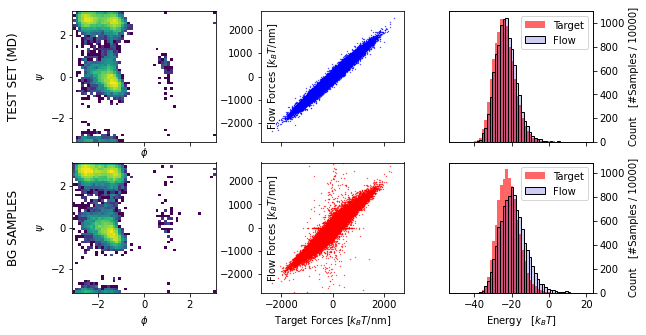

In [23]:
fig, axes = plt.subplots(2,3,figsize=(8,4.5), sharex="col")
fig.tight_layout()

plot_phi_psi(axes[0,0], torch.tensor(data_smooth["samples"]), data.dataset.system)
text1 = axes[0,0].text(-6, 0, "TEST SET (MD)", rotation=90, fontsize=12, va="center")
plot_phi_psi(axes[1,0], torch.tensor(bg_smooth["samples"]), data.dataset.system)
text2 = axes[1,0].text(-6, 0, "BG SAMPLES", rotation=90, fontsize=12, va="center")

ax = axes[0,1]
ax.scatter(data_smooth["model_forces"], data_smooth["target_forces"], s=0.1, color="blue")
ax.set_xlim(-2800., 2800.)
ax.set_ylim(-2800., 2800.)
ax.set_ylabel("Flow Forces [$k_B T$/nm]", labelpad=-60)

ax = axes[1,1]
ax.scatter(bg_smooth["model_forces"], bg_smooth["target_forces"], s=0.1, color="red")
ax.set_xlim(-2800., 2800.)
ax.set_ylim(-2800., 2800.)
ax.set_xlabel("Target Forces [$k_B T$/nm]")
ax.set_ylabel("Flow Forces [$k_B T$/nm]", labelpad=-60)

plot_energies(axes[0,2], data_smooth)
plot_energies(axes[1,2], bg_smooth)
axes[1,2].set_xlabel("Energy   [$k_B T$]")

fig.savefig(f"{MODEL.lower()}_bg.png", dpi=360, extra_bbox_agents=(text1, text2), bbox_inches="tight")
fig.savefig(f"{MODEL.lower()}_bg.pdf", dpi=360, extra_bbox_agents=(text1, text2), bbox_inches="tight")